In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Navier_stan"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_x0 = xyt[NBC_pts_x0,:]
xyt_NBC_x1 = xyt[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xyt_NBC_y1 = xyt[NBC_pts_y1,:]

u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xyt_NBC_y = np.vstack((xyt_NBC_y1))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC_x.shape[0], N_D, replace=False) 
    xyt_Nx = xyt_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xyt_NBC_y.shape[0], N_D, replace=False) 
    xyt_Ny = xyt_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_Nx,xyt_Ny)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_Nx,xyt_Ny

In [7]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
#         self.beta = Parameter(torch.ones((50,len(layers)-2)))
#         self.beta.requiresGrad = True
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z) 
             
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.alpha.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [8]:
max_reps = 1

train_loss_full = []
test_loss_full = []
alpha_full = []
elapsed_time= np.zeros((max_reps,1))

#for reps in range(max_reps):
for reps in range(8,9):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 5000 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_Nx_np_array,xyt_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_Nx = torch.from_numpy(xyt_Nx_np_array).float().to(device)
    xyt_Ny = torch.from_numpy(xyt_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    alpha_full.append(PINN.alpha_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "alpha": alpha_full, "label": label}
savemat(label+'.mat', mdic)

8
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 1683767.5
1 Train Loss 1682067.8
2 Train Loss 1667935.2
3 Train Loss 1618318.5
4 Train Loss 1509106.6
5 Train Loss 1964733.5
6 Train Loss 1488893.6
7 Train Loss 1462808.5
8 Train Loss 1412429.2
9 Train Loss 1344291.0
10 Train Loss 1171534.8
11 Train Loss 9780679.0
12 Train Loss 1067398.

308 Train Loss 200731.72
309 Train Loss 200578.73
310 Train Loss 200987.83
311 Train Loss 200443.77
312 Train Loss 200170.48
313 Train Loss 200038.25
314 Train Loss 213821.44
315 Train Loss 199872.9
316 Train Loss 199811.38
317 Train Loss 200108.06
318 Train Loss 199633.03
319 Train Loss 199531.3
320 Train Loss 199395.83
321 Train Loss 199242.27
322 Train Loss 198997.45
323 Train Loss 198719.97
324 Train Loss 198657.47
325 Train Loss 198723.62
326 Train Loss 198585.23
327 Train Loss 198504.64
328 Train Loss 198363.5
329 Train Loss 198129.64
330 Train Loss 198050.0
331 Train Loss 197934.45
332 Train Loss 197789.12
333 Train Loss 197618.98
334 Train Loss 197290.19
335 Train Loss 197791.75
336 Train Loss 197218.97
337 Train Loss 197069.19
338 Train Loss 196996.1
339 Train Loss 196900.94
340 Train Loss 196641.12
341 Train Loss 196426.42
342 Train Loss 196429.2
343 Train Loss 196159.47
344 Train Loss 195814.31
345 Train Loss 195805.3
346 Train Loss 195684.86
347 Train Loss 195491.92
348 Tra

638 Train Loss 177196.45
639 Train Loss 177149.36
640 Train Loss 177095.0
641 Train Loss 177192.72
642 Train Loss 177079.16
643 Train Loss 177056.92
644 Train Loss 177021.42
645 Train Loss 177004.45
646 Train Loss 176986.89
647 Train Loss 176981.42
648 Train Loss 176968.38
649 Train Loss 176960.89
650 Train Loss 176943.56
651 Train Loss 176925.03
652 Train Loss 176910.9
653 Train Loss 176896.36
654 Train Loss 176884.92
655 Train Loss 176866.7
656 Train Loss 176853.23
657 Train Loss 176842.33
658 Train Loss 176850.02
659 Train Loss 176834.22
660 Train Loss 176819.25
661 Train Loss 176866.98
662 Train Loss 176807.11
663 Train Loss 176788.77
664 Train Loss 176778.17
665 Train Loss 176763.67
666 Train Loss 176753.12
667 Train Loss 176744.73
668 Train Loss 176736.5
669 Train Loss 176730.8
670 Train Loss 176722.31
671 Train Loss 176711.33
672 Train Loss 176700.55
673 Train Loss 176696.02
674 Train Loss 176689.77
675 Train Loss 176685.89
676 Train Loss 176682.22
677 Train Loss 176677.27
678 T

968 Train Loss 172285.75
969 Train Loss 172284.9
970 Train Loss 172274.48
971 Train Loss 172269.38
972 Train Loss 172269.33
973 Train Loss 172265.48
974 Train Loss 172262.27
975 Train Loss 172259.9
976 Train Loss 172258.38
977 Train Loss 172257.72
978 Train Loss 172257.0
979 Train Loss 172256.19
980 Train Loss 172255.3
981 Train Loss 172254.2
982 Train Loss 172252.98
983 Train Loss 172252.06
984 Train Loss 172250.94
985 Train Loss 172249.75
986 Train Loss 172247.92
987 Train Loss 172244.02
988 Train Loss 172239.06
989 Train Loss 172231.77
990 Train Loss 172222.14
991 Train Loss 172209.4
992 Train Loss 172273.95
993 Train Loss 172200.0
994 Train Loss 172236.55
995 Train Loss 172193.67
996 Train Loss 172177.12
997 Train Loss 172153.81
998 Train Loss 172151.28
999 Train Loss 172143.2
1000 Train Loss 172121.39
1001 Train Loss 172131.84
1002 Train Loss 172094.03
1003 Train Loss 172062.45
1004 Train Loss 172022.97
1005 Train Loss 172030.05
1006 Train Loss 171999.36
1007 Train Loss 171978.08


1289 Train Loss 170655.67
1290 Train Loss 170647.45
1291 Train Loss 170636.61
1292 Train Loss 170615.5
1293 Train Loss 170608.05
1294 Train Loss 170601.53
1295 Train Loss 170589.72
1296 Train Loss 170573.44
1297 Train Loss 170570.86
1298 Train Loss 170563.27
1299 Train Loss 170551.84
1300 Train Loss 170530.89
1301 Train Loss 170625.81
1302 Train Loss 170523.89
1303 Train Loss 170506.98
1304 Train Loss 170493.44
1305 Train Loss 170472.38
1306 Train Loss 170457.6
1307 Train Loss 170436.44
1308 Train Loss 170417.48
1309 Train Loss 170398.31
1310 Train Loss 170404.16
1311 Train Loss 170388.23
1312 Train Loss 170380.14
1313 Train Loss 170367.28
1314 Train Loss 170357.55
1315 Train Loss 170351.05
1316 Train Loss 170343.08
1317 Train Loss 170336.95
1318 Train Loss 170331.08
1319 Train Loss 170319.77
1320 Train Loss 170304.1
1321 Train Loss 170298.48
1322 Train Loss 170297.53
1323 Train Loss 170284.16
1324 Train Loss 170276.14
1325 Train Loss 170267.98
1326 Train Loss 170257.02
1327 Train Loss

1607 Train Loss 169277.5
1608 Train Loss 169283.6
1609 Train Loss 169269.98
1610 Train Loss 169262.03
1611 Train Loss 169252.39
1612 Train Loss 169239.66
1613 Train Loss 169237.73
1614 Train Loss 169234.27
1615 Train Loss 169229.7
1616 Train Loss 169225.25
1617 Train Loss 169217.69
1618 Train Loss 169214.58
1619 Train Loss 169213.67
1620 Train Loss 169211.39
1621 Train Loss 169208.44
1622 Train Loss 169206.17
1623 Train Loss 169205.92
1624 Train Loss 169204.42
1625 Train Loss 169201.62
1626 Train Loss 169196.86
1627 Train Loss 169192.03
1628 Train Loss 169188.86
1629 Train Loss 169185.34
1630 Train Loss 169182.84
1631 Train Loss 169179.9
1632 Train Loss 169176.6
1633 Train Loss 169173.78
1634 Train Loss 169172.12
1635 Train Loss 169171.22
1636 Train Loss 169170.08
1637 Train Loss 169169.23
1638 Train Loss 169168.5
1639 Train Loss 169167.8
1640 Train Loss 169166.7
1641 Train Loss 169164.62
1642 Train Loss 169163.22
1643 Train Loss 169161.25
1644 Train Loss 169157.67
1645 Train Loss 1691

1925 Train Loss 168191.14
1926 Train Loss 168190.6
1927 Train Loss 168189.7
1928 Train Loss 168188.62
1929 Train Loss 168187.17
1930 Train Loss 168184.95
1931 Train Loss 168183.66
1932 Train Loss 168182.6
1933 Train Loss 168181.25
1934 Train Loss 168179.89
1935 Train Loss 168178.55
1936 Train Loss 168177.23
1937 Train Loss 168176.08
1938 Train Loss 168175.28
1939 Train Loss 168174.7
1940 Train Loss 168174.44
1941 Train Loss 168173.72
1942 Train Loss 168172.94
1943 Train Loss 168171.52
1944 Train Loss 168175.66
1945 Train Loss 168170.9
1946 Train Loss 168169.48
1947 Train Loss 168167.61
1948 Train Loss 168166.64
1949 Train Loss 168165.69
1950 Train Loss 168163.62
1951 Train Loss 168161.8
1952 Train Loss 168159.38
1953 Train Loss 168157.05
1954 Train Loss 168155.78
1955 Train Loss 168152.38
1956 Train Loss 168150.34
1957 Train Loss 168148.08
1958 Train Loss 168146.11
1959 Train Loss 168143.88
1960 Train Loss 168141.22
1961 Train Loss 168140.25
1962 Train Loss 168136.98
1963 Train Loss 16

2243 Train Loss 167417.9
2244 Train Loss 167416.55
2245 Train Loss 167411.81
2246 Train Loss 167409.56
2247 Train Loss 167407.2
2248 Train Loss 167405.48
2249 Train Loss 167403.92
2250 Train Loss 167400.56
2251 Train Loss 167397.4
2252 Train Loss 167394.73
2253 Train Loss 167390.94
2254 Train Loss 167393.27
2255 Train Loss 167389.22
2256 Train Loss 167387.2
2257 Train Loss 167385.73
2258 Train Loss 167383.45
2259 Train Loss 167380.9
2260 Train Loss 167378.88
2261 Train Loss 167376.52
2262 Train Loss 167374.55
2263 Train Loss 167372.7
2264 Train Loss 167370.4
2265 Train Loss 167367.89
2266 Train Loss 167374.67
2267 Train Loss 167366.45
2268 Train Loss 167364.88
2269 Train Loss 167361.86
2270 Train Loss 167360.3
2271 Train Loss 167358.88
2272 Train Loss 167356.77
2273 Train Loss 167354.69
2274 Train Loss 167352.4
2275 Train Loss 167349.6
2276 Train Loss 167345.69
2277 Train Loss 167344.34
2278 Train Loss 167340.75
2279 Train Loss 167338.58
2280 Train Loss 167334.38
2281 Train Loss 167342

2561 Train Loss 166771.92
2562 Train Loss 166768.7
2563 Train Loss 166770.06
2564 Train Loss 166766.44
2565 Train Loss 166763.22
2566 Train Loss 166760.56
2567 Train Loss 166754.36
2568 Train Loss 166754.95
2569 Train Loss 166750.19
2570 Train Loss 166762.78
2571 Train Loss 166745.28
2572 Train Loss 166741.92
2573 Train Loss 166737.31
2574 Train Loss 166735.06
2575 Train Loss 166733.52
2576 Train Loss 166736.38
2577 Train Loss 166732.75
2578 Train Loss 166732.44
2579 Train Loss 166731.67
2580 Train Loss 166730.64
2581 Train Loss 166729.33
2582 Train Loss 166727.53
2583 Train Loss 166728.25
2584 Train Loss 166726.61
2585 Train Loss 166725.03
2586 Train Loss 166722.5
2587 Train Loss 166726.86
2588 Train Loss 166721.2
2589 Train Loss 166719.48
2590 Train Loss 166717.44
2591 Train Loss 166715.23
2592 Train Loss 166714.81
2593 Train Loss 166714.08
2594 Train Loss 166712.97
2595 Train Loss 166712.12
2596 Train Loss 166711.2
2597 Train Loss 166709.8
2598 Train Loss 166707.78
2599 Train Loss 1

2878 Train Loss 166013.8
2879 Train Loss 165999.23
2880 Train Loss 165994.81
2881 Train Loss 165992.66
2882 Train Loss 165988.92
2883 Train Loss 165987.5
2884 Train Loss 165984.16
2885 Train Loss 165981.55
2886 Train Loss 165979.39
2887 Train Loss 165976.8
2888 Train Loss 165974.1
2889 Train Loss 165972.27
2890 Train Loss 165969.81
2891 Train Loss 165967.42
2892 Train Loss 165964.5
2893 Train Loss 165960.66
2894 Train Loss 165958.5
2895 Train Loss 165956.58
2896 Train Loss 165955.03
2897 Train Loss 165952.89
2898 Train Loss 165950.5
2899 Train Loss 165947.53
2900 Train Loss 165944.17
2901 Train Loss 165940.53
2902 Train Loss 165936.67
2903 Train Loss 165934.69
2904 Train Loss 165931.38
2905 Train Loss 165930.5
2906 Train Loss 165926.25
2907 Train Loss 165923.98
2908 Train Loss 165920.16
2909 Train Loss 165912.8
2910 Train Loss 165909.11
2911 Train Loss 165906.2
2912 Train Loss 165907.08
2913 Train Loss 165903.55
2914 Train Loss 165901.9
2915 Train Loss 165904.11
2916 Train Loss 165898.

3196 Train Loss 164819.84
3197 Train Loss 164816.7
3198 Train Loss 164813.36
3199 Train Loss 164809.9
3200 Train Loss 164803.86
3201 Train Loss 164798.84
3202 Train Loss 164795.2
3203 Train Loss 164791.58
3204 Train Loss 164789.86
3205 Train Loss 164787.17
3206 Train Loss 164785.23
3207 Train Loss 164781.5
3208 Train Loss 164777.2
3209 Train Loss 164776.81
3210 Train Loss 164775.1
3211 Train Loss 164772.73
3212 Train Loss 164772.1
3213 Train Loss 164770.4
3214 Train Loss 164768.34
3215 Train Loss 164763.9
3216 Train Loss 164758.3
3217 Train Loss 164754.48
3218 Train Loss 164750.95
3219 Train Loss 164747.73
3220 Train Loss 164748.92
3221 Train Loss 164745.8
3222 Train Loss 164742.69
3223 Train Loss 164739.97
3224 Train Loss 164737.61
3225 Train Loss 164737.48
3226 Train Loss 164735.8
3227 Train Loss 164735.25
3228 Train Loss 164733.03
3229 Train Loss 164731.36
3230 Train Loss 164728.36
3231 Train Loss 164725.64
3232 Train Loss 164720.17
3233 Train Loss 164715.4
3234 Train Loss 164709.33

3515 Train Loss 163243.72
3516 Train Loss 163230.22
3517 Train Loss 163206.83
3518 Train Loss 163194.17
3519 Train Loss 163185.23
3520 Train Loss 163196.69
3521 Train Loss 163163.17
3522 Train Loss 163161.58
3523 Train Loss 163150.28
3524 Train Loss 163137.98
3525 Train Loss 163130.31
3526 Train Loss 163108.75
3527 Train Loss 163100.92
3528 Train Loss 163089.11
3529 Train Loss 163079.89
3530 Train Loss 163071.3
3531 Train Loss 163070.16
3532 Train Loss 163065.4
3533 Train Loss 163055.53
3534 Train Loss 163048.52
3535 Train Loss 163037.2
3536 Train Loss 163038.28
3537 Train Loss 163029.52
3538 Train Loss 163017.8
3539 Train Loss 163010.25
3540 Train Loss 163004.95
3541 Train Loss 162995.89
3542 Train Loss 162988.44
3543 Train Loss 162988.23
3544 Train Loss 162985.66
3545 Train Loss 162991.19
3546 Train Loss 162982.17
3547 Train Loss 162975.39
3548 Train Loss 162966.81
3549 Train Loss 162960.16
3550 Train Loss 162950.75
3551 Train Loss 162942.66
3552 Train Loss 162931.7
3553 Train Loss 1

3833 Train Loss 161854.33
3834 Train Loss 161852.36
3835 Train Loss 161850.94
3836 Train Loss 161849.45
3837 Train Loss 161847.44
3838 Train Loss 161859.9
3839 Train Loss 161846.38
3840 Train Loss 161843.92
3841 Train Loss 161842.69
3842 Train Loss 161841.8
3843 Train Loss 161840.81
3844 Train Loss 161840.08
3845 Train Loss 161838.88
3846 Train Loss 161837.8
3847 Train Loss 161836.92
3848 Train Loss 161835.72
3849 Train Loss 161833.2
3850 Train Loss 161830.44
3851 Train Loss 161827.6
3852 Train Loss 161824.39
3853 Train Loss 161819.47
3854 Train Loss 161815.02
3855 Train Loss 161810.94
3856 Train Loss 161807.14
3857 Train Loss 161803.72
3858 Train Loss 161799.4
3859 Train Loss 161794.28
3860 Train Loss 161785.62
3861 Train Loss 161778.06
3862 Train Loss 161767.67
3863 Train Loss 163674.5
3864 Train Loss 161773.9
3865 Train Loss 161763.48
3866 Train Loss 161791.84
3867 Train Loss 161755.28
3868 Train Loss 161745.55
3869 Train Loss 161750.34
3870 Train Loss 161735.62
3871 Train Loss 1617

4151 Train Loss 160212.11
4152 Train Loss 160211.53
4153 Train Loss 160210.81
4154 Train Loss 160210.31
4155 Train Loss 160209.86
4156 Train Loss 160209.31
4157 Train Loss 160208.27
4158 Train Loss 160207.2
4159 Train Loss 160205.47
4160 Train Loss 160202.06
4161 Train Loss 160196.75
4162 Train Loss 160192.08
4163 Train Loss 160189.16
4164 Train Loss 160186.11
4165 Train Loss 160184.94
4166 Train Loss 160183.47
4167 Train Loss 160181.28
4168 Train Loss 160178.4
4169 Train Loss 160164.84
4170 Train Loss 160156.83
4171 Train Loss 160148.56
4172 Train Loss 160139.11
4173 Train Loss 160131.52
4174 Train Loss 160126.55
4175 Train Loss 160116.4
4176 Train Loss 160113.4
4177 Train Loss 160100.47
4178 Train Loss 160096.3
4179 Train Loss 160086.8
4180 Train Loss 160076.16
4181 Train Loss 160064.61
4182 Train Loss 160062.0
4183 Train Loss 160055.61
4184 Train Loss 160047.69
4185 Train Loss 160089.22
4186 Train Loss 160042.05
4187 Train Loss 160035.66
4188 Train Loss 160029.53
4189 Train Loss 160

4469 Train Loss 158074.33
4470 Train Loss 158069.8
4471 Train Loss 158067.4
4472 Train Loss 158064.55
4473 Train Loss 158061.77
4474 Train Loss 158059.8
4475 Train Loss 158054.8
4476 Train Loss 158049.3
4477 Train Loss 158043.28
4478 Train Loss 158034.19
4479 Train Loss 158023.19
4480 Train Loss 158005.83
4481 Train Loss 157992.47
4482 Train Loss 157982.17
4483 Train Loss 157973.83
4484 Train Loss 157965.28
4485 Train Loss 157953.22
4486 Train Loss 157940.56
4487 Train Loss 157928.6
4488 Train Loss 157913.38
4489 Train Loss 157905.67
4490 Train Loss 157898.88
4491 Train Loss 157893.88
4492 Train Loss 157886.36
4493 Train Loss 157877.52
4494 Train Loss 436430.12
4495 Train Loss 160656.83
4496 Train Loss 157902.1
4497 Train Loss 157861.31
4498 Train Loss 159292.69
4499 Train Loss 157892.56
4500 Train Loss 157859.34
4501 Train Loss 157851.55
4502 Train Loss 157841.58
4503 Train Loss 157835.08
4504 Train Loss 157826.67
4505 Train Loss 157811.73
4506 Train Loss 157783.53
4507 Train Loss 157

4787 Train Loss 154931.7
4788 Train Loss 154928.98
4789 Train Loss 154925.86
4790 Train Loss 154916.98
4791 Train Loss 154906.75
4792 Train Loss 154889.89
4793 Train Loss 154885.78
4794 Train Loss 154872.25
4795 Train Loss 154866.61
4796 Train Loss 154856.67
4797 Train Loss 154849.06
4798 Train Loss 154840.58
4799 Train Loss 154828.2
4800 Train Loss 154824.3
4801 Train Loss 154818.92
4802 Train Loss 154814.33
4803 Train Loss 154806.69
4804 Train Loss 154796.17
4805 Train Loss 154779.44
4806 Train Loss 154752.11
4807 Train Loss 154740.08
4808 Train Loss 154716.06
4809 Train Loss 154695.0
4810 Train Loss 154666.36
4811 Train Loss 154640.88
4812 Train Loss 154590.2
4813 Train Loss 154567.53
4814 Train Loss 154553.97
4815 Train Loss 154534.8
4816 Train Loss 154515.95
4817 Train Loss 154498.17
4818 Train Loss 154470.77
4819 Train Loss 154456.53
4820 Train Loss 154443.53
4821 Train Loss 154419.77
4822 Train Loss 154393.7
4823 Train Loss 154358.64
4824 Train Loss 154320.45
4825 Train Loss 154

5105 Train Loss 149837.95
5106 Train Loss 149860.11
5107 Train Loss 149824.44
5108 Train Loss 149863.6
5109 Train Loss 149809.4
5110 Train Loss 149786.22
5111 Train Loss 149781.62
5112 Train Loss 149773.67
5113 Train Loss 149751.6
5114 Train Loss 149745.02
5115 Train Loss 149729.69
5116 Train Loss 149721.36
5117 Train Loss 149710.98
5118 Train Loss 149698.55
5119 Train Loss 149682.47
5120 Train Loss 149660.89
5121 Train Loss 149646.38
5122 Train Loss 149618.73
5123 Train Loss 149590.34
5124 Train Loss 149556.8
5125 Train Loss 149543.47
5126 Train Loss 149531.31
5127 Train Loss 149531.48
5128 Train Loss 149524.22
5129 Train Loss 149521.55
5130 Train Loss 149510.12
5131 Train Loss 149491.64
5132 Train Loss 149472.58
5133 Train Loss 149449.39
5134 Train Loss 149448.31
5135 Train Loss 149430.05
5136 Train Loss 149427.84
5137 Train Loss 149414.28
5138 Train Loss 149404.39
5139 Train Loss 149393.25
5140 Train Loss 149389.77
5141 Train Loss 149376.39
5142 Train Loss 149369.12
5143 Train Loss 

5423 Train Loss 146297.62
5424 Train Loss 146292.06
5425 Train Loss 146277.81
5426 Train Loss 146250.25
5427 Train Loss 146242.92
5428 Train Loss 146236.19
5429 Train Loss 146262.83
5430 Train Loss 146227.17
5431 Train Loss 146219.81
5432 Train Loss 146211.97
5433 Train Loss 146198.14
5434 Train Loss 146183.97
5435 Train Loss 146172.88
5436 Train Loss 146167.78
5437 Train Loss 146163.36
5438 Train Loss 146159.61
5439 Train Loss 146153.98
5440 Train Loss 146147.92
5441 Train Loss 146138.94
5442 Train Loss 146121.69
5443 Train Loss 146083.39
5444 Train Loss 146138.52
5445 Train Loss 146070.94
5446 Train Loss 146047.28
5447 Train Loss 146024.52
5448 Train Loss 145999.89
5449 Train Loss 146005.72
5450 Train Loss 145984.84
5451 Train Loss 145988.55
5452 Train Loss 145975.17
5453 Train Loss 145973.72
5454 Train Loss 145962.8
5455 Train Loss 145952.06
5456 Train Loss 145940.81
5457 Train Loss 146123.17
5458 Train Loss 145934.39
5459 Train Loss 145921.28
5460 Train Loss 145938.23
5461 Train Lo

5742 Train Loss 142465.56
5743 Train Loss 142460.84
5744 Train Loss 142453.73
5745 Train Loss 142447.84
5746 Train Loss 142442.7
5747 Train Loss 142438.75
5748 Train Loss 142436.34
5749 Train Loss 142433.4
5750 Train Loss 142431.08
5751 Train Loss 142427.84
5752 Train Loss 142418.67
5753 Train Loss 142408.61
5754 Train Loss 142401.69
5755 Train Loss 142398.7
5756 Train Loss 142376.02
5757 Train Loss 142367.16
5758 Train Loss 142368.98
5759 Train Loss 142360.56
5760 Train Loss 142357.62
5761 Train Loss 142347.06
5762 Train Loss 142341.66
5763 Train Loss 142335.06
5764 Train Loss 142325.39
5765 Train Loss 142319.77
5766 Train Loss 142316.12
5767 Train Loss 142311.2
5768 Train Loss 142308.1
5769 Train Loss 142303.86
5770 Train Loss 142298.67
5771 Train Loss 142298.12
5772 Train Loss 142291.56
5773 Train Loss 142285.58
5774 Train Loss 142278.84
5775 Train Loss 142271.08
5776 Train Loss 142261.22
5777 Train Loss 142256.12
5778 Train Loss 142252.75
5779 Train Loss 142250.52
5780 Train Loss 1

6060 Train Loss 140506.67
6061 Train Loss 140503.08
6062 Train Loss 140501.03
6063 Train Loss 140498.66
6064 Train Loss 140493.2
6065 Train Loss 143244.16
6066 Train Loss 140498.17
6067 Train Loss 140492.19
6068 Train Loss 140486.73
6069 Train Loss 140482.14
6070 Train Loss 140482.38
6071 Train Loss 140478.66
6072 Train Loss 140473.88
6073 Train Loss 140467.58
6074 Train Loss 140461.45
6075 Train Loss 140453.75
6076 Train Loss 140446.22
6077 Train Loss 140456.19
6078 Train Loss 140442.47
6079 Train Loss 140434.9
6080 Train Loss 140428.78
6081 Train Loss 140420.39
6082 Train Loss 140419.61
6083 Train Loss 140416.81
6084 Train Loss 140410.72
6085 Train Loss 140405.62
6086 Train Loss 140403.83
6087 Train Loss 140398.61
6088 Train Loss 140392.52
6089 Train Loss 140386.38
6090 Train Loss 140379.27
6091 Train Loss 140374.06
6092 Train Loss 140372.31
6093 Train Loss 140365.89
6094 Train Loss 140366.0
6095 Train Loss 140364.4
6096 Train Loss 140365.14
6097 Train Loss 140363.28
6098 Train Loss 

6378 Train Loss 138731.3
6379 Train Loss 138736.33
6380 Train Loss 138720.2
6381 Train Loss 138712.31
6382 Train Loss 138723.2
6383 Train Loss 138700.31
6384 Train Loss 138684.47
6385 Train Loss 138680.73
6386 Train Loss 138672.8
6387 Train Loss 138646.17
6388 Train Loss 138629.1
6389 Train Loss 138602.19
6390 Train Loss 138604.95
6391 Train Loss 138585.81
6392 Train Loss 138697.1
6393 Train Loss 138567.2
6394 Train Loss 138565.81
6395 Train Loss 138554.61
6396 Train Loss 138544.17
6397 Train Loss 138545.25
6398 Train Loss 138529.67
6399 Train Loss 138530.66
6400 Train Loss 138518.86
6401 Train Loss 138511.0
6402 Train Loss 138500.75
6403 Train Loss 138495.78
6404 Train Loss 138494.7
6405 Train Loss 138490.16
6406 Train Loss 138485.56
6407 Train Loss 138477.05
6408 Train Loss 138468.17
6409 Train Loss 138458.42
6410 Train Loss 138448.5
6411 Train Loss 138443.55
6412 Train Loss 138438.9
6413 Train Loss 138435.47
6414 Train Loss 138430.22
6415 Train Loss 138423.4
6416 Train Loss 138418.7

6697 Train Loss 136327.39
6698 Train Loss 136323.08
6699 Train Loss 136318.25
6700 Train Loss 136311.42
6701 Train Loss 136311.22
6702 Train Loss 136308.22
6703 Train Loss 136309.19
6704 Train Loss 136304.03
6705 Train Loss 136301.47
6706 Train Loss 136299.52
6707 Train Loss 136298.02
6708 Train Loss 136296.62
6709 Train Loss 136293.61
6710 Train Loss 136293.84
6711 Train Loss 136291.92
6712 Train Loss 136288.58
6713 Train Loss 136283.77
6714 Train Loss 136289.16
6715 Train Loss 136281.98
6716 Train Loss 136278.84
6717 Train Loss 136277.14
6718 Train Loss 136274.3
6719 Train Loss 136271.38
6720 Train Loss 136266.69
6721 Train Loss 136260.94
6722 Train Loss 136255.44
6723 Train Loss 136253.0
6724 Train Loss 136249.34
6725 Train Loss 136247.3
6726 Train Loss 136244.88
6727 Train Loss 136243.16
6728 Train Loss 136241.38
6729 Train Loss 136238.12
6730 Train Loss 136233.17
6731 Train Loss 136298.83
6732 Train Loss 136231.27
6733 Train Loss 136225.7
6734 Train Loss 136215.7
6735 Train Loss 1

7016 Train Loss 134867.53
7017 Train Loss 134837.95
7018 Train Loss 134827.14
7019 Train Loss 134827.69
7020 Train Loss 134804.8
7021 Train Loss 134823.12
7022 Train Loss 134790.55
7023 Train Loss 134772.23
7024 Train Loss 134746.12
7025 Train Loss 134729.52
7026 Train Loss 134879.31
7027 Train Loss 134704.27
7028 Train Loss 134822.69
7029 Train Loss 134674.77
7030 Train Loss 134640.1
7031 Train Loss 134637.08
7032 Train Loss 134618.78
7033 Train Loss 134617.08
7034 Train Loss 134606.05
7035 Train Loss 134595.73
7036 Train Loss 134585.28
7037 Train Loss 134586.14
7038 Train Loss 134575.55
7039 Train Loss 134569.27
7040 Train Loss 134563.2
7041 Train Loss 134557.0
7042 Train Loss 134553.33
7043 Train Loss 134548.25
7044 Train Loss 134541.53
7045 Train Loss 134535.23
7046 Train Loss 134533.39
7047 Train Loss 134530.3
7048 Train Loss 134528.53
7049 Train Loss 134526.28
7050 Train Loss 134524.47
7051 Train Loss 134522.22
7052 Train Loss 134520.7
7053 Train Loss 134519.81
7054 Train Loss 13

7334 Train Loss 132838.16
7335 Train Loss 132836.55
7336 Train Loss 132834.97
7337 Train Loss 132833.3
7338 Train Loss 132832.42
7339 Train Loss 132831.38
7340 Train Loss 132830.83
7341 Train Loss 132829.89
7342 Train Loss 132828.52
7343 Train Loss 132826.78
7344 Train Loss 132824.47
7345 Train Loss 132821.67
7346 Train Loss 132827.02
7347 Train Loss 132820.56
7348 Train Loss 132818.72
7349 Train Loss 132816.69
7350 Train Loss 132814.14
7351 Train Loss 132812.92
7352 Train Loss 132811.84
7353 Train Loss 132810.44
7354 Train Loss 132808.78
7355 Train Loss 132806.25
7356 Train Loss 132803.89
7357 Train Loss 132802.89
7358 Train Loss 132801.62
7359 Train Loss 132800.7
7360 Train Loss 132798.25
7361 Train Loss 132794.3
7362 Train Loss 132790.48
7363 Train Loss 132789.92
7364 Train Loss 132787.95
7365 Train Loss 132783.56
7366 Train Loss 132780.4
7367 Train Loss 132777.77
7368 Train Loss 132780.06
7369 Train Loss 132775.81
7370 Train Loss 132771.97
7371 Train Loss 132767.64
7372 Train Loss 

7652 Train Loss 131715.11
7653 Train Loss 131703.28
7654 Train Loss 131696.64
7655 Train Loss 131687.9
7656 Train Loss 131680.9
7657 Train Loss 131675.84
7658 Train Loss 131667.75
7659 Train Loss 131666.16
7660 Train Loss 131663.95
7661 Train Loss 131657.83
7662 Train Loss 131656.97
7663 Train Loss 131654.34
7664 Train Loss 131648.77
7665 Train Loss 131645.66
7666 Train Loss 131642.16
7667 Train Loss 131638.31
7668 Train Loss 131634.64
7669 Train Loss 131630.78
7670 Train Loss 131626.73
7671 Train Loss 131623.84
7672 Train Loss 131613.5
7673 Train Loss 131618.5
7674 Train Loss 131609.47
7675 Train Loss 131602.19
7676 Train Loss 131592.16
7677 Train Loss 131590.22
7678 Train Loss 131584.27
7679 Train Loss 131582.47
7680 Train Loss 131577.61
7681 Train Loss 131575.81
7682 Train Loss 131568.84
7683 Train Loss 131566.67
7684 Train Loss 131562.53
7685 Train Loss 131560.17
7686 Train Loss 131557.27
7687 Train Loss 131552.75
7688 Train Loss 131546.52
7689 Train Loss 131760.67
7690 Train Loss 

7969 Train Loss 130198.47
7970 Train Loss 130196.44
7971 Train Loss 130193.4
7972 Train Loss 130190.195
7973 Train Loss 130186.984
7974 Train Loss 130183.125
7975 Train Loss 130183.01
7976 Train Loss 130181.086
7977 Train Loss 130178.39
7978 Train Loss 130174.56
7979 Train Loss 130170.984
7980 Train Loss 130165.98
7981 Train Loss 130165.86
7982 Train Loss 130163.234
7983 Train Loss 130158.945
7984 Train Loss 130157.016
7985 Train Loss 130153.39
7986 Train Loss 130152.125
7987 Train Loss 130149.23
7988 Train Loss 130145.82
7989 Train Loss 130144.25
7990 Train Loss 130141.56
7991 Train Loss 130139.28
7992 Train Loss 130136.61
7993 Train Loss 130133.664
7994 Train Loss 130130.12
7995 Train Loss 130126.68
7996 Train Loss 130122.09
7997 Train Loss 130115.68
7998 Train Loss 130105.93
7999 Train Loss 130094.195
8000 Train Loss 130080.11
8001 Train Loss 130395.33
8002 Train Loss 130070.47
8003 Train Loss 130078.8
8004 Train Loss 130058.32
8005 Train Loss 130098.32
8006 Train Loss 130050.484
80

8284 Train Loss 128696.57
8285 Train Loss 128691.52
8286 Train Loss 128686.05
8287 Train Loss 128682.74
8288 Train Loss 128680.44
8289 Train Loss 128679.805
8290 Train Loss 128677.99
8291 Train Loss 128676.74
8292 Train Loss 128674.73
8293 Train Loss 128672.336
8294 Train Loss 128669.91
8295 Train Loss 128667.71
8296 Train Loss 128663.92
8297 Train Loss 128657.12
8298 Train Loss 128652.086
8299 Train Loss 128650.125
8300 Train Loss 128648.195
8301 Train Loss 128665.05
8302 Train Loss 128645.89
8303 Train Loss 128641.57
8304 Train Loss 128636.44
8305 Train Loss 128630.805
8306 Train Loss 128621.91
8307 Train Loss 128618.03
8308 Train Loss 128611.13
8309 Train Loss 128607.45
8310 Train Loss 128617.84
8311 Train Loss 128604.24
8312 Train Loss 128605.73
8313 Train Loss 128602.08
8314 Train Loss 128600.15
8315 Train Loss 128594.73
8316 Train Loss 128590.72
8317 Train Loss 128587.14
8318 Train Loss 128581.99
8319 Train Loss 128578.52
8320 Train Loss 128574.2
8321 Train Loss 128570.555
8322 T

8599 Train Loss 127407.31
8600 Train Loss 127403.94
8601 Train Loss 127399.66
8602 Train Loss 127392.516
8603 Train Loss 127387.77
8604 Train Loss 127397.445
8605 Train Loss 127384.4
8606 Train Loss 127379.71
8607 Train Loss 127372.055
8608 Train Loss 127366.8
8609 Train Loss 127356.54
8610 Train Loss 127360.89
8611 Train Loss 127349.43
8612 Train Loss 127347.77
8613 Train Loss 127343.2
8614 Train Loss 127340.445
8615 Train Loss 127338.65
8616 Train Loss 127336.875
8617 Train Loss 127334.484
8618 Train Loss 127332.24
8619 Train Loss 127328.375
8620 Train Loss 127322.39
8621 Train Loss 127319.945
8622 Train Loss 127314.55
8623 Train Loss 127310.78
8624 Train Loss 127306.414
8625 Train Loss 127302.97
8626 Train Loss 127298.38
8627 Train Loss 127293.38
8628 Train Loss 127288.44
8629 Train Loss 127283.055
8630 Train Loss 127278.445
8631 Train Loss 127278.21
8632 Train Loss 127276.91
8633 Train Loss 127274.914
8634 Train Loss 127272.375
8635 Train Loss 127269.88
8636 Train Loss 127265.19
86

8914 Train Loss 126171.08
8915 Train Loss 126167.04
8916 Train Loss 126161.89
8917 Train Loss 126156.11
8918 Train Loss 126148.016
8919 Train Loss 126136.91
8920 Train Loss 126135.29
8921 Train Loss 126131.5
8922 Train Loss 126127.16
8923 Train Loss 126132.484
8924 Train Loss 126124.57
8925 Train Loss 126118.484
8926 Train Loss 126111.36
8927 Train Loss 126102.7
8928 Train Loss 126096.11
8929 Train Loss 126090.59
8930 Train Loss 126084.41
8931 Train Loss 126080.69
8932 Train Loss 126077.68
8933 Train Loss 126076.43
8934 Train Loss 126074.93
8935 Train Loss 126072.61
8936 Train Loss 126070.93
8937 Train Loss 126068.086
8938 Train Loss 126072.09
8939 Train Loss 126067.164
8940 Train Loss 126065.945
8941 Train Loss 126064.69
8942 Train Loss 126063.24
8943 Train Loss 126062.06
8944 Train Loss 126060.62
8945 Train Loss 126059.44
8946 Train Loss 126058.5
8947 Train Loss 126057.5
8948 Train Loss 126056.29
8949 Train Loss 126054.75
8950 Train Loss 126053.2
8951 Train Loss 126051.65
8952 Train 

9229 Train Loss 124748.91
9230 Train Loss 124747.46
9231 Train Loss 124744.62
9232 Train Loss 124742.98
9233 Train Loss 124740.33
9234 Train Loss 124737.46
9235 Train Loss 124734.43
9236 Train Loss 124734.67
9237 Train Loss 124732.51
9238 Train Loss 138268.36
9239 Train Loss 124904.05
9240 Train Loss 124729.12
9241 Train Loss 124726.92
9242 Train Loss 124725.016
9243 Train Loss 124725.91
9244 Train Loss 124724.195
9245 Train Loss 124724.836
9246 Train Loss 124722.75
9247 Train Loss 124721.05
9248 Train Loss 124720.12
9249 Train Loss 124717.01
9250 Train Loss 124715.0
9251 Train Loss 124712.82
9252 Train Loss 124709.98
9253 Train Loss 124707.23
9254 Train Loss 124704.586
9255 Train Loss 124702.31
9256 Train Loss 124702.03
9257 Train Loss 124702.33
9258 Train Loss 124700.16
9259 Train Loss 124698.57
9260 Train Loss 124697.375
9261 Train Loss 124694.24
9262 Train Loss 124692.336
9263 Train Loss 124689.63
9264 Train Loss 124685.734
9265 Train Loss 124684.305
9266 Train Loss 124681.1
9267 T

9545 Train Loss 123922.64
9546 Train Loss 123921.51
9547 Train Loss 123920.766
9548 Train Loss 123919.92
9549 Train Loss 123918.914
9550 Train Loss 123915.73
9551 Train Loss 123977.95
9552 Train Loss 123914.88
9553 Train Loss 123912.26
9554 Train Loss 123908.266
9555 Train Loss 123905.266
9556 Train Loss 123902.84
9557 Train Loss 123900.266
9558 Train Loss 123896.516
9559 Train Loss 123892.01
9560 Train Loss 123890.68
9561 Train Loss 123889.34
9562 Train Loss 123887.22
9563 Train Loss 123884.305
9564 Train Loss 123881.78
9565 Train Loss 123879.56
9566 Train Loss 123877.39
9567 Train Loss 123872.76
9568 Train Loss 123869.47
9569 Train Loss 123864.66
9570 Train Loss 123859.79
9571 Train Loss 123873.97
9572 Train Loss 123856.836
9573 Train Loss 123854.086
9574 Train Loss 123851.42
9575 Train Loss 123848.92
9576 Train Loss 123845.57
9577 Train Loss 123842.43
9578 Train Loss 123840.28
9579 Train Loss 123838.805
9580 Train Loss 123838.61
9581 Train Loss 123837.51
9582 Train Loss 123835.71
95

9861 Train Loss 123114.74
9862 Train Loss 123109.68
9863 Train Loss 123106.54
9864 Train Loss 123104.21
9865 Train Loss 123104.73
9866 Train Loss 123102.29
9867 Train Loss 123100.164
9868 Train Loss 123097.164
9869 Train Loss 123095.31
9870 Train Loss 123093.76
9871 Train Loss 123091.805
9872 Train Loss 123093.13
9873 Train Loss 123090.734
9874 Train Loss 123088.086
9875 Train Loss 123085.805
9876 Train Loss 123084.16
9877 Train Loss 123082.71
9878 Train Loss 123081.43
9879 Train Loss 123079.77
9880 Train Loss 123077.82
9881 Train Loss 123074.12
9882 Train Loss 123072.17
9883 Train Loss 123070.77
9884 Train Loss 123068.45
9885 Train Loss 123066.64
9886 Train Loss 123064.29
9887 Train Loss 123059.6
9888 Train Loss 123056.125
9889 Train Loss 123050.086
9890 Train Loss 123040.836
9891 Train Loss 123045.0
9892 Train Loss 123035.69
9893 Train Loss 123028.89
9894 Train Loss 123025.6
9895 Train Loss 123029.66
9896 Train Loss 123023.3
9897 Train Loss 123020.71
9898 Train Loss 123017.016
9899 T

10170 Train Loss 122317.164
10171 Train Loss 122314.96
10172 Train Loss 122312.72
10173 Train Loss 122309.67
10174 Train Loss 122306.42
10175 Train Loss 122304.016
10176 Train Loss 122302.516
10177 Train Loss 122300.14
10178 Train Loss 122300.1
10179 Train Loss 122298.74
10180 Train Loss 122297.47
10181 Train Loss 122295.664
10182 Train Loss 122293.41
10183 Train Loss 122290.71
10184 Train Loss 122287.08
10185 Train Loss 122283.5
10186 Train Loss 122278.89
10187 Train Loss 122275.766
10188 Train Loss 122271.54
10189 Train Loss 122267.305
10190 Train Loss 122262.086
10191 Train Loss 122261.73
10192 Train Loss 122258.305
10193 Train Loss 122256.13
10194 Train Loss 122253.09
10195 Train Loss 122248.516
10196 Train Loss 122244.01
10197 Train Loss 122239.48
10198 Train Loss 122232.57
10199 Train Loss 122226.0
10200 Train Loss 122235.8
10201 Train Loss 122223.34
10202 Train Loss 122219.31
10203 Train Loss 122213.195
10204 Train Loss 122210.97
10205 Train Loss 122206.336
10206 Train Loss 1222

10473 Train Loss 121736.63
10474 Train Loss 121735.43
10475 Train Loss 121733.914
10476 Train Loss 121732.57
10477 Train Loss 121730.85
10478 Train Loss 121729.1
10479 Train Loss 121727.05
10480 Train Loss 121725.51
10481 Train Loss 121724.54
10482 Train Loss 121722.76
10483 Train Loss 121721.07
10484 Train Loss 121719.555
10485 Train Loss 121718.38
10486 Train Loss 121717.05
10487 Train Loss 121715.67
10488 Train Loss 121714.63
10489 Train Loss 121713.91
10490 Train Loss 121712.945
10491 Train Loss 121711.73
10492 Train Loss 121710.45
10493 Train Loss 121708.66
10494 Train Loss 121706.65
10495 Train Loss 121705.44
10496 Train Loss 121703.01
10497 Train Loss 121701.125
10498 Train Loss 121698.49
10499 Train Loss 121697.58
10500 Train Loss 121697.086
10501 Train Loss 121695.87
10502 Train Loss 121695.65
10503 Train Loss 121694.28
10504 Train Loss 121692.17
10505 Train Loss 121688.42
10506 Train Loss 121686.875
10507 Train Loss 121684.77
10508 Train Loss 121686.02
10509 Train Loss 121683

10777 Train Loss 121150.95
10778 Train Loss 121143.54
10779 Train Loss 121140.62
10780 Train Loss 121129.38
10781 Train Loss 121118.34
10782 Train Loss 121108.14
10783 Train Loss 121105.01
10784 Train Loss 121106.96
10785 Train Loss 121100.05
10786 Train Loss 121097.14
10787 Train Loss 121095.49
10788 Train Loss 121092.55
10789 Train Loss 121090.516
10790 Train Loss 121089.22
10791 Train Loss 121088.37
10792 Train Loss 121086.22
10793 Train Loss 121085.63
10794 Train Loss 121081.68
10795 Train Loss 121079.8
10796 Train Loss 121075.766
10797 Train Loss 121069.32
10798 Train Loss 121064.375
10799 Train Loss 121059.24
10800 Train Loss 121060.71
10801 Train Loss 121054.734
10802 Train Loss 121046.14
10803 Train Loss 121037.26
10804 Train Loss 121019.38
10805 Train Loss 121011.71
10806 Train Loss 121024.3
10807 Train Loss 121006.05
10808 Train Loss 121010.54
10809 Train Loss 121002.25
10810 Train Loss 121000.67
10811 Train Loss 120997.74
10812 Train Loss 120994.93
10813 Train Loss 120991.11

11080 Train Loss 120430.766
11081 Train Loss 120429.234
11082 Train Loss 120423.54
11083 Train Loss 120420.58
11084 Train Loss 120415.7
11085 Train Loss 120411.24
11086 Train Loss 120408.66
11087 Train Loss 120407.56
11088 Train Loss 120406.44
11089 Train Loss 120404.52
11090 Train Loss 120402.76
11091 Train Loss 120400.14
11092 Train Loss 120397.55
11093 Train Loss 120396.1
11094 Train Loss 120394.23
11095 Train Loss 120393.5
11096 Train Loss 120391.71
11097 Train Loss 120390.79
11098 Train Loss 120389.88
11099 Train Loss 120388.56
11100 Train Loss 120387.28
11101 Train Loss 120385.1
11102 Train Loss 120384.15
11103 Train Loss 120382.875
11104 Train Loss 120382.7
11105 Train Loss 120381.695
11106 Train Loss 120379.65
11107 Train Loss 120377.89
11108 Train Loss 120375.516
11109 Train Loss 120373.91
11110 Train Loss 120372.26
11111 Train Loss 120369.92
11112 Train Loss 120367.68
11113 Train Loss 120364.79
11114 Train Loss 120364.31
11115 Train Loss 120361.79
11116 Train Loss 120363.45
1

IndexError: index 8 is out of bounds for axis 0 with size 1

In [9]:
del xyt_coll
del xyt_D

In [10]:
u_pred = PINN.test(xyt_test_tensor)
u_pred_3d = u_pred.reshape(100,100,100,order = 'F')

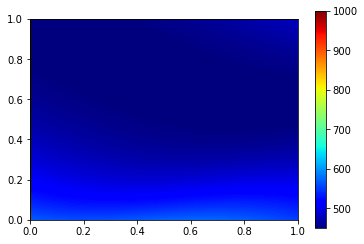

In [11]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(u_pred_3d[:,:,50]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
fig.colorbar(img3, orientation='vertical')

In [12]:
import subprocess
import os

In [20]:
def generate_video():
    for i in range(100):
        #plt.imshow(img[i], cmap=cm.Greys_r)
        img3 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
        
        plt.savefig("stan_heat_%02d.png" % i)

    #os.chdir()
    subprocess.call(['ffmpeg', '-framerate', '8', '-i', 'stan_heat_%02d.png', '-r', '10', '-pix_fmt', 'yuv420p','Stan_transient.mp4'])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [21]:
generate_video()

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

<Figure size 432x288 with 0 Axes>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


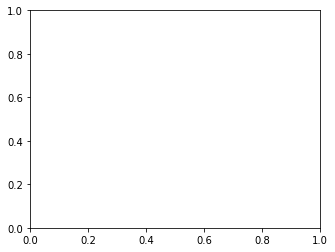

In [13]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
# img = [] # some array of images
frames = [] # for storing the generated images
# fig = plt.figure()
for i in range(100):
#     p1 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
#     fig.colorbar(p1, orientation='vertical',ax=ax)
    frames.append([plt.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)])
    print(i)

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
#ani.save('movie.mp4')
plt.show()

In [14]:
writergif = animation.PillowWriter(fps=10)
ani.save('atanh_Thinplate_movie.gif',writer=writergif)

In [35]:
writervideo = animation.FFMpegWriter(fps=60) 
ani.save('Stan_Thinplate_movie1.gif',writer=writervideo)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

In [ ]:
np.max(u_pred_3d[:,:,50])

In [ ]:
plt.plot(u_pred_3d[50,99,:])

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)